# Problem 
Kenneth has $4 and David has $3. They each bet $1 on a fair coin flip until one of them runs out of money. What is the relative probability of each one winning

# Solution:
Much of the math used here was taken from:

https://www.dartmouth.edu/~chance/teaching_aids/books_articles/probability_book/Chapter11.pdf


Model the system as an absorbing Markov chain with state space:

    states = {0, 1, 2, 3, 4, 5, 6, 7}

where each state corresponding to the amount of money currently held by one person. States 0 and 7 are the absorbing states, i.e., once the system enters those states they cannot transition to other states. States 1-5 are transition states.
    
Probability of transitioning from current state to -1 or +1 state is 0.5 and 0 for all other states

    P(i,i+1) = 0.5
    P(i+1,i) = 0.5

Once in the winning state, stay in the winning state

    P(7,7) = 1

Similarly, once in the losing state, stay in the losing state

    P(0,0) = 1
    

### Canonical form
With the transition probability matrix in hand, we can re-write it in canonical form:

\begin{equation}
  P = \begin{bmatrix}
    Q & R \\
    0 & I 
  \end{bmatrix}
\end{equation}

where $Q$ describes the probabilities of transitioning among the transient statess, $R$ descfibes the probabilities of transitioning from transient states to absorbing states, and I is the identity matrix.

The probability of transitining from state $i$ to state $j$ after n steps (or n flips in this case) is given by the $(i,j)$ entry in $Q^n$.

### Fundamental matrix

By summing $Q^k$ from $k=0$ to $k=\infty$, we get the expectation for the number of times the system is in state $j$ if it started in state $i$, which is the fundamental matrix, $N$. This the the sum of the probabilities for transitioning from/to each state over all possible states of the system (0 steps, or coin flips, to $\infty$ steps, or coin flips). It has been proven (certainly not by me) that:

\begin{equation}
N = \sum _ { k = 0 } ^ { \infty } Q ^ { k } = \left( I _ { t } - Q \right) ^ { - 1 }
\end{equation}

We can use the fundamental matrix with the components of the transition matrix in fundamental form to calculate lots of useful quantities!

### Absorption probabilities
We are trying to calculate the relative probabilities of David or Kenneth winning the bet, i.e., the probabilities of ending up in either absorbing state given a particular starting state (in this case the starting state is 3 or 4, depending on whom we're modeling).

Since we know the probabilities for transitioning from transient states to absorbing states, $R$, and the expected number of times the system is in each state, $N$, we can calculate the absorbtion probabilities:

\begin{equation}
B = NR
\end{equation}

Each entry in B is the probability of starting in state $i$ and being absorbed into state $j$.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

%matplotlib inline
plt.style.use('seaborn')

In [3]:
# Define the total amount of money in play and initialize the transition matrix
total_dollars = 7
P = np.zeros(shape=(total_dollars+1, total_dollars+1))

# Probabilty of transitioning to -1/+1 state = 0.5
for i in range(P.shape[0]-1):
    P[i,i+1] = .5
    P[i+1,i] = .5
    
# Once in the winning or losing sate, i.e., all money or no money, stay there
P[0,:] = 0
P[0,0] = 1
P[total_dollars,:] = 0
P[total_dollars, total_dollars] = 1
    
# Check that all rows are normalized to 1
assert np.all(np.sum(P,axis=1)==1), 'Rows are not properly normalized'

In [4]:
# Express the transition matrix in canonical form
# Move transition probabilities from/to absorbing states to the last rows/cols
C = deepcopy(P)
C = np.roll(C,-1,axis=0)
C = np.roll(C,-1, axis=1)

# Matrix indices now refer to following states:
state_order = [1,2,3,4,5,6,7,0]
#    e.g. C(0,7) == P(state 1 -> state 0) = 0.5 
#    e.g. C(6,6) == P(state 7 -> state 7) = 1


# Fundamental matrix, N,  gives the expected number of times that the system will be
# in each transient state before absorbing given a particular starting state (row)
# Fundamental matrix N = (I-Q)^-1
Q = C[:6,:6]
I = np.identity(6)
N = np.linalg.inv(I-Q)

# R matrix of absorbtion probabilities 
R = C[:6,6:]

# Probability of each starting state ending in absorbing state
# B = NR
B = np.dot(N,R)

In [5]:
print('P(David wins) = {:.3f}'.format(B[2,0]))
print('P(Kenneth wins) = {:.3f}'.format(1-B[2,0]))

P(David wins) = 0.429
P(Kenneth wins) = 0.571


## Evolution of system after N flips
Just fo fun - we can see how the system evolves with coin flips

In [6]:
# Get the transition matrix after n_flips
def flip(n_flips):
    return np.linalg.matrix_power(P,n_flips)   

In [7]:
# Define initial state where David has $3
initial_state = np.zeros(total_dollars+1)
initial_state[3] = 1

In [8]:
n_flips = 50
states = np.ndarray(shape=(n_flips, initial_state.shape[0]))
for n in range(n_flips):
    states[n] = np.dot(initial_state, flip(n))
    
# Note that this is the probability of David or Kenneth winning after 50 flips, but there is a high probability of 
# ending up in an absorbing sate well before the 50th flip
print('Probablity that David wins after {} flips   = {:.8f}'.format(n_flips, states[n_flips-1, -1]))
print('Probablity that Kenneth wins after {} flips = {:.8f}'.format(n_flips, states[n_flips-1, 0]))

Probablity that David wins after 50 flips   = 0.42469608
Probablity that Kenneth wins after 50 flips = 0.56793700


Text(45, 0.5779370049294636, '0.57')

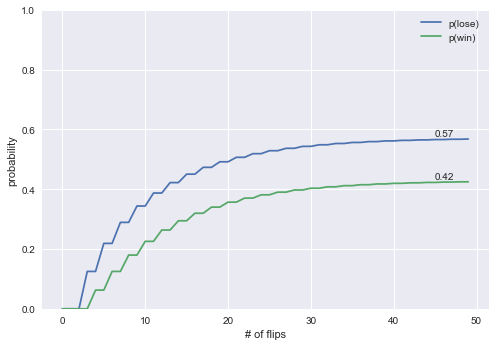

In [9]:
# Plot probability of being in the winning and losing states as a function of n coin flips
fig, ax = plt.subplots()
s = np.arange(n_flips)
ax.plot(s, states[:,0], label='p(lose)')
ax.plot(s, states[:,total_dollars], label='p(win)')
ax.set_ylim([0,1])
ax.set_xlabel('# of flips')
ax.set_ylabel('probability')
ax.legend()

p_win = states[-1,total_dollars]
p_lose = states[-1,0]
ax.annotate('{:.2f}'.format(p_win), xy=(n_flips-5, p_win+.01), textcoords='data')
ax.annotate('{:.2f}'.format(p_lose), xy=(n_flips-5, p_lose+.01), textcoords='data')

Text(0, 0.5, 'state')

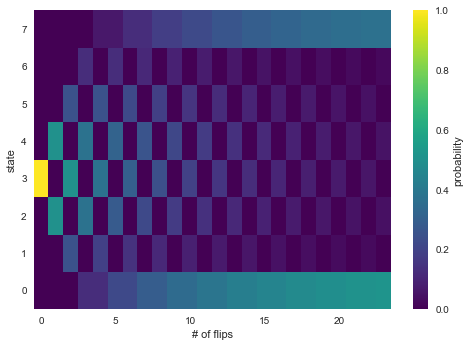

In [10]:
# Plot colormap of the probability of being in each state after n flips
fig, ax = plt.subplots()
im = ax.pcolormesh(s[:25] - .5, np.arange(total_dollars+2)-.5, states[:25,:].T, cmap='viridis')
plt.colorbar(im, label='probability')

ax.set_xlabel('# of flips')
ax.set_ylabel('state')